This is a simple example of how the various parts of the package can be combined to learn a sampling pattern.

In [1]:
%pylab inline
from bilevelmri.experiment_setup import learn, compute_statistics
from bilevelmri.linear_ops.gradients import Grad
from bilevelmri.functionals import Smoothed1Norm
from bilevelmri.loss_functions import least_squares
from bilevelmri.penalty_functions import l1_disc_penalty
from bilevelmri.parametrisations import alpha_parametrisation, free_parametrisation

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch

torch.set_default_dtype(torch.float64)

In [3]:
x = torch.zeros(1, 32, 32, 2)
x[0, 8:24, 8:24, 0] = 1.
y = torch.fft(x, signal_ndim=2, normalized=True) + 0.03 * torch.randn_like(x)
data = {'x': x, 'y': y}
n1, n2 = x.shape[1:3]

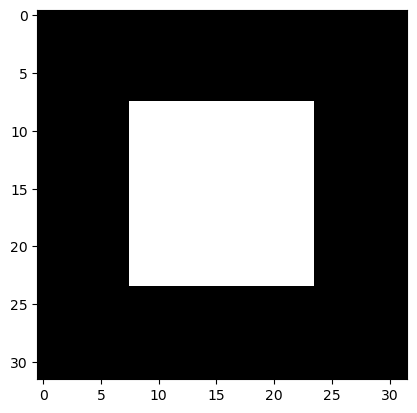

In [12]:
imshow(x[0,:,:,0], cmap='gray')

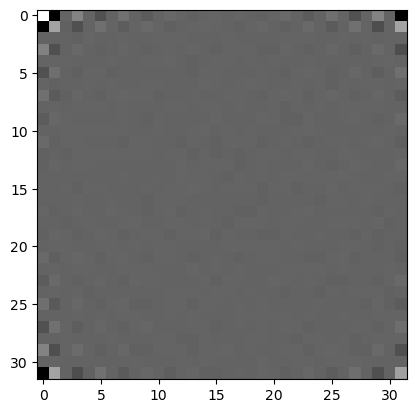

In [13]:
imshow(y[0,:,:,0], cmap='gray')

In [5]:
params = {
    'model': {
        'n1': n1,
        'n2': n2
    },
    'alg_params': {
        'll_sol': {
            'maxit': 1000,
            'tol': 1e-10
        },
        'lin_sys': {
            'maxit': 1000,
            'tol': 1e-6
        },
        'LBFGSB': {
            'maxit': 1000,
            'pgtol': 1e-8
        }
    }
}

A = Grad()
reg_func = Smoothed1Norm(gamma=1e-2)


def penalty(p):
    return l1_disc_penalty(p[:-2], beta=(.1, .1))

In [8]:
# tune alpha on full sampling pattern to get initialisation
tuned_alpha = learn(data, 1e-3, [(0, np.inf)], alpha_parametrisation, A,
                    reg_func, least_squares, lambda p: torch.zeros_like(p),
                    params)

Learning sampling pattern:
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 2.53e-04
Iteration 250: Relative error: 6.42e-09
Finishing at iteration 295: Relative error: 8.81e-11
CG converged within tolerance 1.00e-06 at iteration 4: relative error was 1.36e-07
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 4.48e-04
Iteration 250: Relative error: 5.56e-05
Iteration 375: Relative error: 8.27e-06
Iteration 500: Relative error: 1.30e-06
Iteration 625: Relative error: 2.11e-07
Iteration 750: Relative error: 3.48e-08
Iteration 875: Relative error: 5.84e-09
Iteration 1000: Relative error: 9.92e-10
CG converged within tolerance 1.00e-06 at iteration 68: relative error was 8.30e-07

Iteration #1: Current sampling rate 100.0%, alpha 6.96e-02, eps 1.00e-02
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 2.36e-04
Iteration 250: Relative error: 1.72e-05
Iteration 37

In [9]:
tuned_alpha

{'elapsed_time': datetime.timedelta(seconds=70, microseconds=714977),
 'p': array([0.03651037]),
 'info': {'grad': array([-1.26061467e-10]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 12,
  'nit': 8,
  'warnflag': 0}}

In [ ]:
p_init = np.ones(n1 * n2 + 2)
p_init[-1] = 1e-2
p_init[-2] = tuned_alpha['p']
p_bounds = [(0., 1.) for _ in range(n1 * n2)]
p_bounds.append((0, np.inf))
p_bounds.append((1e-2, 1e-2))
# learn sampling pattern
result = learn(data, p_init, p_bounds, free_parametrisation, A, reg_func,
               least_squares, penalty, params)

stats = compute_statistics(data, result['p'], A, reg_func, free_parametrisation, params)

Learning sampling pattern:
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 1.06e-04
Iteration 250: Relative error: 3.43e-06
Iteration 375: Relative error: 1.67e-07
Iteration 500: Relative error: 9.54e-09
Iteration 625: Relative error: 5.98e-10
Finishing at iteration 708: Relative error: 9.82e-11
CG converged within tolerance 1.00e-06 at iteration 45: relative error was 9.22e-07
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 1.06e-04
Iteration 250: Relative error: 3.43e-06
Iteration 375: Relative error: 1.67e-07
Iteration 500: Relative error: 9.54e-09
Iteration 625: Relative error: 5.98e-10
Finishing at iteration 708: Relative error: 9.82e-11
CG converged within tolerance 1.00e-06 at iteration 45: relative error was 9.22e-07

Iteration #1: Current sampling rate 100.0%, alpha 3.38e-02, eps 1.00e-02
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 1.06e-04

In [ ]:
result

{'elapsed_time': datetime.timedelta(seconds=1344, microseconds=207447),
 'p': array([0.        , 1.        , 0.        , ..., 1.        , 0.01047328,
        0.01      ]),
 'info': {'grad': array([ 1.95312500e-04, -9.13543452e-06,  1.95312500e-04, ...,
         -6.87531896e-06,  3.82706640e-10,  1.25564632e-02]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 457,
  'nit': 312,
  'warnflag': 0}}

Text(0.5, 1.0, 'Reconstruction with learned pattern')

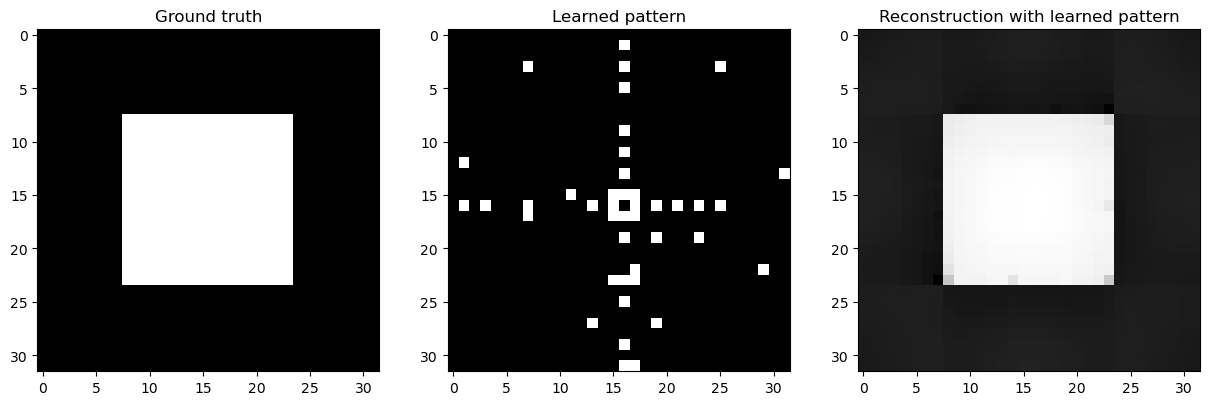

In [ ]:
rcParams['figure.figsize'] = (15, 15)
subplot(1, 3, 1)
imshow(torch.sqrt(torch.sum(data['x'][0, :, :, :]**2, dim=2)), cmap='gray')
title('Ground truth')
subplot(1, 3, 2)
imshow(fftshift(result['p'][:-2].reshape(n1, n2)), cmap='gray')
title('Learned pattern')
subplot(1, 3, 3)
imshow(torch.sqrt(torch.sum(stats['recons'][0, :, :, :]**2, dim=2)), cmap='gray')
title('Reconstruction with learned pattern')